In [ ]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram, array_to_latex,plot_distribution
from qiskit.circuit.library import Initialize
import qiskit_aer
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel,pauli_error
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import Statevector, state_fidelity, partial_trace, DensityMatrix, random_statevector
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from IPython.display import display
simulator_aer=AerSimulator()
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from collections import Counter
from qiskit.visualization import plot_distribution

This code implements the Shor code to run on IBM Quantum 

In [ ]:
def shor_error_correction(psi,d=False, x_a=False,x_b=False,x_c=False,z_a=False):
    qr = QuantumRegister(9,"q")
    qr_b=QuantumRegister(6, 'q_b')
    qr_p=QuantumRegister(2, 'q_p')
    cr_main = ClassicalRegister(1, "c_main")  # For the first qubit
    cr_b1 = ClassicalRegister(2, "c_b1")
    cr_b2 = ClassicalRegister(2, "c_b2")
    cr_b3 = ClassicalRegister(2, "c_b3")
 
    cr_p= ClassicalRegister(2, "c_p")
    qc = QuantumCircuit(qr,qr_b,qr_p,cr_b1,cr_b2,cr_b3,cr_p,cr_main)

    # Initialize the state
    init_gate = Initialize(psi)
    qc.append(init_gate, [qr[0]])
    qc.barrier()

    # --- ENCODING ---
    qc.cx(qr[0],qr[3])
    qc.cx(qr[0],qr[6])

    qc.h(qr[0])
    qc.h(qr[3])
    qc.h(qr[6])

    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])

    qc.cx(qr[3],qr[4])
    qc.cx(qr[3],qr[5])

    qc.cx(qr[6],qr[7])
    qc.cx(qr[6],qr[8])

    #errors here
    if x_a:
        qc.x(qr[0])
    if x_b:
        qc.x(qr[1])
    if x_c:
        qc.x(qr[2]) 

    qc.barrier()

    #----BITFLIP CORRECTION----
    #Measure parities of the three triplets q0q1q2 using qb0 and qb1, q3q4q5 using qb2 and qb3, q6q7q8 using qb4 and qb5. Then, apply the conditional x gates based on the outcome

    if d:
        #first triplet
        qc.cx(qr[0],qr_b[0])
        qc.cx(qr[1],qr_b[0])
        qc.cx(qr[1],qr_b[1])
        qc.cx(qr[2],qr_b[1])
        qc.measure(qr_b[0], cr_b1[0])
        qc.measure(qr_b[1], cr_b1[1])
        qc.x(qr[0]).c_if(cr_b1, 1)
        qc.x(qr[1]).c_if(cr_b1, 3)
        qc.x(qr[2]).c_if(cr_b1, 2)
        qc.barrier()
        #second triplet
        qc.cx(qr[3],qr_b[2])
        qc.cx(qr[4],qr_b[2])
        qc.cx(qr[4],qr_b[3])
        qc.cx(qr[5],qr_b[3])
        qc.measure(qr_b[2], cr_b2[0])
        qc.measure(qr_b[3], cr_b2[1])
        qc.x(qr[3]).c_if(cr_b2, 1)
        qc.x(qr[4]).c_if(cr_b2, 3)
        qc.x(qr[5]).c_if(cr_b2, 2)
        qc.barrier()

        #third triplet
        qc.cx(qr[6],qr_b[4])
        qc.cx(qr[7],qr_b[4])
        qc.cx(qr[7],qr_b[5])
        qc.cx(qr[8],qr_b[5])
        qc.measure(qr_b[4], cr_b3[0])
        qc.measure(qr_b[5], cr_b3[1])
        qc.x(qr[6]).c_if(cr_b3, 1)
        qc.x(qr[7]).c_if(cr_b3, 3)
        qc.x(qr[8]).c_if(cr_b3, 2)
        qc.barrier()

    #Z error
    if z_a:
        qc.z(qr[0])

    #Partially uncode qubit
    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])

    qc.cx(qr[3],qr[4])
    qc.cx(qr[3],qr[5])

    qc.cx(qr[6],qr[7])
    qc.cx(qr[6],qr[8])

    qc.h(qr[0])
    qc.h(qr[3])
    qc.h(qr[6])

    #----PHASEFLIP CORRECTION----

    if d:

        #Compute phase parities and store them in the ancillas
        qc.barrier()

        qc.cx(qr[0],qr_p[0])
        qc.cx(qr[3],qr_p[0])
        qc.cx(qr[3],qr_p[1])
        qc.cx(qr[6],qr_p[1])
        qc.measure(qr_p[0], cr_p[0])
        qc.measure(qr_p[1], cr_p[1])
        qc.h(qr[0])
        qc.h(qr[3])
        qc.h(qr[6])
        qc.z(qr[0]).c_if(cr_p, 1)
        qc.z(qr[3]).c_if(cr_p, 3)
        qc.z(qr[6]).c_if(cr_p, 2)
        qc.h(qr[0])
        qc.h(qr[3])
        qc.h(qr[6])

    qc.barrier()

    #Reencode qubit

    qc.h(qr[0])
    qc.h(qr[3])
    qc.h(qr[6])

    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])

    qc.cx(qr[3],qr[4])
    qc.cx(qr[3],qr[5])

    qc.cx(qr[6],qr[7])
    qc.cx(qr[6],qr[8])

    # --- DECODING ---
    qc.barrier()

    qc.cx(qr[0],qr[1])
    qc.cx(qr[0],qr[2])

    qc.cx(qr[3],qr[4])
    qc.cx(qr[3],qr[5])

    qc.cx(qr[6],qr[7])
    qc.cx(qr[6],qr[8])

    qc.h(qr[0])
    qc.h(qr[3])
    qc.h(qr[6])

    qc.cx(qr[0],qr[3])
    qc.cx(qr[0],qr[6])


    # Uncompute initialization
    qc.append(init_gate.gates_to_uncompute(), [qr[0]])
    qc.measure(qr[0], cr_main[0])

    #display(qc.draw("mpl")) 

    return qc

Start session and choose IBM computer, define transpilation

In [ ]:
#create session
QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='51ad803f351a05ad2639020de513f4d227f2ddc1cd58e253f7bb66ccf7dba6a546ec3c03a789d67aecd048774bb07bad64db1ea32e050844b427eebdda5c5aec', overwrite=True)
#start session as
service=QiskitRuntimeService()
# check the available devices right now:
print(service.backends())
# check the available devices right now and choose manually:
print(service.backends())
backend = service.backend("ibm_brisbane")
print(backend)
#transpilation for real quantum devices is a bit different (change of versions...)
pm=generate_preset_pass_manager(target=backend.target)

Study of performance of 10 different states first for correction applied:

In [121]:
n_states=10
psi_list = [random_statevector(2) for _ in range(n_states)]
circuits = []
tags=[]
for psi in psi_list:
    qc = shor_error_correction(psi, d=True) 
    circuits.append(pm.run(qc))

sampler = SamplerV2(mode=backend)
job = sampler.run(circuits, shots=1024)
result = job.result()


c:\Users\alfon\miniconda3\envs\qiskit-env-1\lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:857: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


Tells you when the result is ready

In [122]:
job.status()

'DONE'

Given the previous result, this code s

In [ ]:
fidelities = []
for idx in range(n_states):
    bitarray = result[idx].data.c_main 
    raw_bytes = bitarray._array # Obtain results from exact state by extracting bytes
    num_bits = bitarray.num_bits  # Obtain significative bits per byte
    bit_strings = [
        format(byte[0], f"0{num_bits}b")  # '0' o '1'
        for byte in raw_bytes
    ]
    counts = Counter(bit_strings) #Counts each time you get 0 or 1
    p0 = counts.get("0", 0) / 1024
    fidelities.append(p0)

average_fidelity = sum(fidelities) / len(fidelities)
print(f"\n Average fidelity for correction: {average_fidelity:.4f}")


 Average Fidelity for correction: 0.4785


Do the same for no correction case

In [130]:
service=QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
circuits = []
tags=[]
for psi in psi_list:
    qc = shor_error_correction(psi, d=False) 
    circuits.append(pm.run(qc))

sampler = SamplerV2(mode=backend)
job_1 = sampler.run(circuits, shots=1024)
result_1 = job_1.result()


c:\Users\alfon\miniconda3\envs\qiskit-env-1\lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:857: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


In [115]:
job.status()

'DONE'

In [ ]:
fidelities_1 = []
for idx in range(n_states):
    bitarray = result_1[idx].data.c_main
    raw_bytes = bitarray._array
    num_bits = bitarray.num_bits        
    bit_strings = [
        format(byte[0], f"0{num_bits}b") 
        for byte in raw_bytes
    ]
    counts = Counter(bit_strings)
    p0 = counts.get("0", 0) / 1024
    fidelities_1.append(p0)

average_fidelity_1 = sum(fidelities_1) / len(fidelities_1)
print(f"\n Average fidelity for no correction: {average_fidelity_1:.4f}")



 Average Fidelity for no correction: 0.5816


Final plot for comparison

(0.0, 1.0)

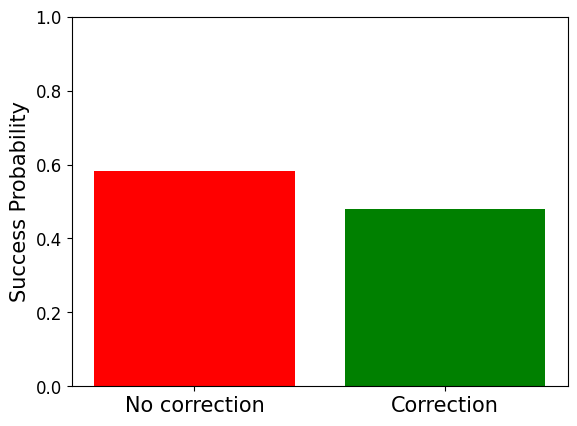

In [ ]:
labels = ['No correction', 'Correction']
values = [average_fidelity_1, average_fidelity]

plt.bar(labels, values, color=['red', 'green'])

plt.ylabel('Success Probability', fontsize=15)
plt.xticks(fontsize=15)

plt.yticks(fontsize=12)
plt.ylim(0, 1)  